<a href="https://colab.research.google.com/github/vacheharutyunyan/machine-learning-projects/blob/main/MLP_and_Backpropagatio_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Differentiation

Please show the derivation to each answer for each problem. Use LaTeX to write up the answers.

## Exercise 1:
$$  
y = x^Tx,  \quad x \in \mathbb{R}^N
$$

$$
\frac{\partial y}{\partial x} = 2x
$$

## Exercise 2:
$$ y = tr(AB) \quad A,B \in \mathbb{R}^{N \times N} $$

$$
\frac{\partial}{\partial a_{ij}} y = b_{ji}
$$

$$
\frac{dy}{dA} = B^T
$$

## Exercise 3:
$$  
y = x^TAc , \quad A\in \mathbb{R}^{N \times N}, x\in \mathbb{R}^{N}, c\in \mathbb{R}^{N}
$$

$$
\frac{dy}{dA} = xc^T
$$

## Exercise 4:
$$
J = || X - AS ||_2^2  , \quad A\in \mathbb{R}^{N \times R} , \quad S\in \mathbb{R}^{R \times M}
$$

$$
\frac{dJ}{dS} = 2(A^TAS - A^TX)
$$

# Part 1: Build Your Own Deep Learning Framework

## Objective
We have seen how to write a Neural Network using raw NumPy (hard) and PyTorch (easy). To truly understand what happens inside `loss.backward()`, you will build a mini-PyTorch from scratch using NumPy.

## Instructions
1.  **Do not use PyTorch, TensorFlow, or Autograd.** Use only `numpy`.
2.  We provide the structure (`Module`, `Sequential`).
3.  You must implement the `updateOutput` (Forward) and `updateGradInput`/`accGradParameters` (Backward) for:
    * `Linear` (Dense Layer)
    * `ReLU` (Activation)
    * `SoftMax` (Activation)
    * `CrossEntropyCriterion` (Loss)
4.  Finally, train a model on the MNIST dataset using your framework.

In [ ]:
import numpy as np

class Module(object):
    """
    Abstract Class for a Neural Network Module.
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Computes the output of the module.
        """
        return self.updateOutput(input)

    def backward(self, input, gradOutput):
        """
        Performs a backpropagation step.
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateOutput(self, input):
        """
        Specific to the module. Computes self.output
        """
        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        """
        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        """
        pass

    def zeroGradParameters(self):
        pass

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def __repr__(self):
        return "Module"

class Sequential(Module):
    """
    A container that processes input sequentially through a list of modules.
    """
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        # We need to pass the input of layer i to the backward of layer i
        # But we only stored the final output in updateOutput.
        # We need to re-compute or store intermediate inputs during forward.
        # For simplicity here, let's re-run forward for inputs (naive)
        # OR better: assume the user calls forward first and we can track inputs.

        # NOTE for Students:
        # In a real framework, we store inputs. Here, to keep it simple,
        # we iterate backwards.

        # 1. Get the inputs for each layer.
        inputs = [input]
        for i in range(len(self.modules) - 1):
            inputs.append(self.modules[i].output)

        # 2. Iterate backwards
        self.gradInput = gradOutput
        for i in range(len(self.modules) - 1, -1, -1):
            self.gradInput = self.modules[i].backward(inputs[i], self.gradInput)

        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]

## Task 1: Linear Layer
Implement the fully connected layer.
Formula: $Y = X W^T + b$

In [ ]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):

        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):

        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):

        self.gradW = gradOutput.T @ input
        self.gradb = gradOutput.sum(axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        return f'Linear {self.W.shape[1]} -> {self.W.shape[0]}'

## Task 2: Activation Functions
Implement ReLU and SoftMax.
**SoftMax Hint:** Subtract the max value from the input before exponentiating to avoid numerical overflow.
$$\text{SoftMax}(x_i) = \frac{e^{x_i - \max(x)}}{\sum e^{x_j - \max(x)}}$$

In [ ]:
class ReLU(Module):
    def updateOutput(self, input):
        # TODO: self.output = max(0, input)
        self.output = np.maximum(0, input)
        return self.output

    def updateGradInput(self, input, gradOutput):

        self.gradInput = np.where(input > 0, gradOutput, 0)

        return self.gradInput

class SoftMax(Module):
    def updateOutput(self, input):

        input_max = np.max(input, axis=1, keepdims=True)
        input_exp = np.exp(input - input_max)
        self.output = input_exp / np.sum(input_exp, axis=1, keepdims=True)

        return self.output

    def updateGradInput(self, input, gradOutput):

        softmax = self.output
        self.gradInput = softmax * (gradOutput - np.sum(softmax * gradOutput, axis=1, keepdims=True))
        return self.gradInput

## Task 3: Criterion (Loss Function)
Implement the Negative Log Likelihood (Cross Entropy) for multiclass classification.

In [ ]:
class ClassNLLCriterion(object):
    def updateOutput(self, input, target):
        # input: probability distribution (output of SoftMax)
        # target: one-hot encoded or integer indices

        # Use this trick to avoid numerical errors (log(0))
        eps = 1e-15
        input_clamp = np.clip(input, eps, 1 - eps)

        # TODO: Calculate Negative Log Likelihood
        self.output = -np.sum(target * np.log(input_clamp))

        return self.output

    def updateGradInput(self, input, target):
        # TODO: Calculate gradient
        eps = 1e-15
        input_clamp = np.clip(input, eps, 1 - eps)
        self.gradInput = -target / input_clamp

        return self.gradInput

## Task 4: Putting it all together (MNIST)
1. Load MNIST data (use `sklearn.datasets.load_digits` or `torchvision`).
2. Preprocess: Normalize to [0,1], One-hot encode targets.
3. Build a `Sequential` model: Linear -> ReLU -> Linear -> SoftMax.
4. Write a training loop using SGD.
5. Plot the loss.

Epoch 5/200, Loss: 5.2680
Epoch 10/200, Loss: 2.9064
Epoch 15/200, Loss: 2.0460
Epoch 20/200, Loss: 1.4117
Epoch 25/200, Loss: 0.9613
Epoch 30/200, Loss: 0.7395
Epoch 35/200, Loss: 0.5835
Epoch 40/200, Loss: 0.4877
Epoch 45/200, Loss: 0.4101
Epoch 50/200, Loss: 0.3221
Epoch 55/200, Loss: 0.3006
Epoch 60/200, Loss: 0.2571
Epoch 65/200, Loss: 0.2190
Epoch 70/200, Loss: 0.1953
Epoch 75/200, Loss: 0.1717
Epoch 80/200, Loss: 0.1524
Epoch 85/200, Loss: 0.1476
Epoch 90/200, Loss: 0.1352
Epoch 95/200, Loss: 0.1226
Epoch 100/200, Loss: 0.1176
Epoch 105/200, Loss: 0.1059
Epoch 110/200, Loss: 0.1008
Epoch 115/200, Loss: 0.0954
Epoch 120/200, Loss: 0.0903
Epoch 125/200, Loss: 0.0843
Epoch 130/200, Loss: 0.0785
Epoch 135/200, Loss: 0.0742
Epoch 140/200, Loss: 0.0722
Epoch 145/200, Loss: 0.0678
Epoch 150/200, Loss: 0.0655
Epoch 155/200, Loss: 0.0634
Epoch 160/200, Loss: 0.0599
Epoch 165/200, Loss: 0.0580
Epoch 170/200, Loss: 0.0553
Epoch 175/200, Loss: 0.0532
Epoch 180/200, Loss: 0.0517
Epoch 185/20

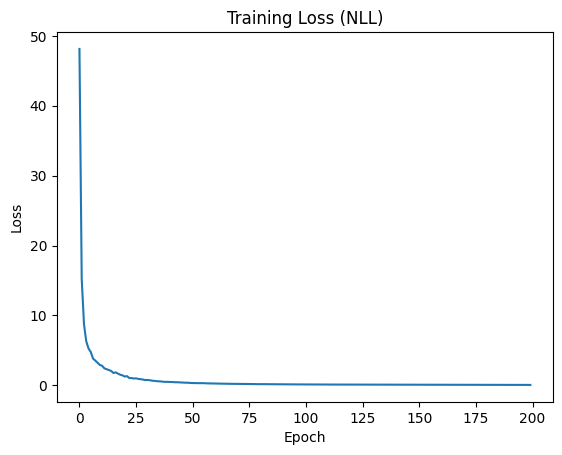

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target.reshape(-1, 1)

X = X / 16.0

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)


model = Sequential()
model.add(Linear(64,128))
model.add(ReLU())
model.add(Linear(128,10))
model.add(SoftMax())

loss_fn = ClassNLLCriterion()
learning_rate = 0.01
n_epochs = 200
batch_size = 32

loss_history = []


for epoch in range(n_epochs):

    idx = np.random.permutation(len(X_train))
    X_train = X_train[idx]
    y_train = y_train[idx]

    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        probs = model.forward(X_batch)
        loss = loss_fn.updateOutput(probs, y_batch)
        epoch_loss += loss * X_batch.shape[0]

        model.zeroGradParameters()
        gradOutput = loss_fn.updateGradInput(probs, y_batch)
        model.backward(X_batch, gradOutput)

        for layer in model.modules:
            for param, grad in zip(layer.getParameters(), layer.getGradParameters()):
                param -= learning_rate * grad

    epoch_loss /= len(X_train)
    loss_history.append(epoch_loss)
    if (epoch+1)%5==0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")


model.evaluate()
probs_test = model.forward(X_test)
y_pred = np.argmax(probs_test, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true)
print(f"Test Accuracy: {accuracy*100:.2f}%")


plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (NLL)")
plt.show()
